# Too Many Features: Overfitting
Module 1 | Chapter 1 | Notebook 7

***
If you give a machine learning model too much freedom to learn, then it learns the data by heart, so to speak, and and can no longer be used to make good predictions. If there are too many free parameters that are adapted to the data, this is called overfitting. Every slope in a linear regression model is a parameter in this way. You'll learn exactly what this is all about in this lesson. By the end of this exercise you will be able to:
* Detect overfitting
* Avoid overfitting
***


## Creating a Baseline Model


**Scenario:** A Taiwanese investor comes to you to find out how much his properties in Taiwan are actually worth. He might want to resell them. The data on the houses is located in *Taiwan_real_estate_prediction_data.xlsx*. 

He looked at your prediction based on the proximity to the nearest metro station and/or on the age of the house.  He would now like a prediction based on all the features we have. Is this kind of multiple linear regression model the best? The training data is in *Taiwan_real_estate_training_data.xlsx*.


In order to get started quickly, let's import the data and process it like we did in the last lesson.


In [1]:
import pandas as pd
df = pd.read_excel('Taiwan_real_estate_training_data.xlsx', index_col='No')
col_names = ['house_age', 
              'metro_distance', 
              'number_convenience_stores', 
              'number_parking_spaces',
              'air_pollution',
              'light_pollution',
              'noise_pollution',
              'neighborhood_quality',
              'crime_score',
              'energy_consumption',
              'longitude', 
              'price_per_ping']
df.columns = col_names
df.loc[:, 'price_per_m2'] = df.loc[:, 'price_per_ping'] / 3.3

The data dictionary for this data is as follows:

Column number | Column name       | Type      | Description
 ------------ | ---     | :---------:           | ------------:
0              | `'house_age'` | continuous (`float`) | age of the house in years
1              | `'metro_distance'` | continuous (`float`) | distance in meters to the next metro station
2              | `'number_convenience_stores'` | continuous (`int`) | Number of convenience stores nearby
3              | `'number_parking_spaces'` | continuous (`int`) | Number of parking spaces nearby
4              | `'air_pollution'` | continuous (`float`) | Air pollution value near the house
5              | `'light_pollution'` | continuous (`float`) | Light pollution value near the house
6              | `'light_pollution'` | continuous (`float`) | Light pollution value near the house
7              | `'neighborhood_quality'` | continuous (`float`) | average quality of life in the neighborhood
8              | `'crime_score'` | continuous (`float`) | crime score according to police
9              | `'energy_consumption'` | continuous (`float`) | The property's energy consumption
10              | `'longitude'` | continuous (`float`) | The property's longitude
11              | `'price_per_ping'` | continuous (`float`) | House price in Taiwan dollars per ping, one ping is 3.3 m²
12              | `'price_per_ping'` | continuous (`float`) | House price in Taiwan dollars per m²


Now let's get straight to the real estate investor's request. Use a multiple linear regression model to predict property prices based on the following features:
```python
['house_age',
 'metro_distance', 
 'number_convenience_stores', 
 'number_parking_spaces',
 'air_pollution',
 'light_pollution',
 'noise_pollution',
 'neighborhood_quality',
 'crime_score',
 'energy_consumption',
 'longitude']
```
Save the feature matrix in `features_multiple_all`. Store the model in `model_multiple_all`. Print the slopes and intercept.


In [2]:
from sklearn.linear_model import LinearRegression
model_multiple_all = LinearRegression()

features_multiple_all = df.loc[:, ['house_age',
 'metro_distance', 
 'number_convenience_stores', 
 'number_parking_spaces',
 'air_pollution',
 'light_pollution',
 'noise_pollution',
 'neighborhood_quality',
 'crime_score',
 'energy_consumption',
 'longitude']]
target = df.loc[:,'price_per_m2']
model_multiple_all.fit( features_multiple_all, target)


import numpy as np; np.set_printoptions(suppress=True)  # suppress scientific notation for ease of interpretation
print('Slope: ', model_multiple_all.coef_)  # beta (slope)
print('Intercept: ', model_multiple_all.intercept_)  # intercept

Slope:  [ -0.08080605  -0.00157327   0.58572668  -0.02730774  -0.00143356
   0.00496967  -0.02051466   2.27005373  -0.15999745  -0.00045578
 -31.99795736]
Intercept:  3901.708990997849


We end up with the following regression formula:

\begin{equation*}
house price\, \ per\, \ m² = 3902 - (0.081 \cdot house age) - (0.002 \cdot metro distance) + (0.586 \cdot number \, food stores) - (0.03 \cdot number \, parking spaces) - (0.001 \cdot air pollution value) + (0.005 \cdot light pollution value) - (0.02 \cdot noise pollution value) + (2.27 \cdot neighborhood value) - (0.16 \cdot crime value) - (0.0005 \cdot energy consumption) - (32.00 \cdot latitude)
\end{equation*}

How good is this kind of large multiple linear regression model? Calculate the mean squared error (*mean squared error*), the RMSE (*rooted mean squared error*) and the coefficient of determination (*R²*)


In [3]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

target_pred = model_multiple_all.predict(features_multiple_all)
print('MSE: ', mean_squared_error(target, target_pred))
print('RMSE: ', np.sqrt(mean_squared_error(target, target_pred)))
print('R2: ', r2_score(target, target_pred))


MSE:  7.766393941469823
RMSE:  2.786825064741205
R2:  0.565862831083511


The values look very good. If we compare them with the model quality metrics calculated so far, it becomes apparent that this model is better than all the others.

Model| MSE| *R²*
---|---|---
`model_age`| 16.97 | 5.1%
`model_metro`| 10.07 | 43.6%
`model_stores`| 12.21 | 31.8% 
`model_multiple`| 9.34 | 47.8% 
`model_multiple_all`| 7.76 | 56.6%


We will use this model as the *baseline model*. It will be a guide as to whether our optimization steps are taking us in the right direction.


**Congratulations:** The large multiple linear regression model looks very good according to the model quality metrics. As data scientists, we are particularly interested in the how accurate our model's predictions are. In general, you shouldn't evaluate your model with the same data the algorithm used to learn. Now you'll see why.


## Independent test data


**Scenario:** The Taiwanese investor doesn't completely trust the large multiple linear regression model. He also put some data to one side to use for a test. You weren't able to use this data during the training phase. How well our model can predict this test data will now be the deciding factor in which model is the most reliable. The test data is stored in *Taiwan_real_estate_test_data.xlsx*.


First import *Taiwan_real_estate_test_data.xlsx* and store the data in `df_test`. Calculate the `'price_per_m2'` column using the following formula:

\begin{equation*}
House price\, \ per\, \ square\,meter = \frac{House price\, \ per\, \ ping}{3,3}
\end{equation*}

and add it to `df_test`. Then print the first 5 rows (all columns) of `df_test`.

Tip: Use the `'No'` column as the row name column again. Rename the columns just like you did with `df` by using `col_names`.


In [4]:
df_test = pd.read_excel('Taiwan_real_estate_test_data.xlsx', index_col='No')
df_test.columns = col_names
df_test.loc[:, 'price_per_m2'] = df_test.loc[:, 'price_per_ping'] / 3.3
df_test.head()

,house_age,metro_distance,number_convenience_stores,number_parking_spaces,air_pollution,light_pollution,noise_pollution,neighborhood_quality,crime_score,energy_consumption,longitude,price_per_ping,price_per_m2
No,,,,,,,,,,,,,
315,3.7,577.9615,6,108,480.000000,1.099596,146.430378,0.485457,0.556433,103.639798,121.54722,41.6,12.606061
316,15.6,1756.4110,2,54,1607.727683,1.456661,229.970916,0.390628,0.850871,56.356143,121.51812,27.3,8.272727
317,13.3,250.6310,7,83,34.689814,6.098307,273.824975,0.631295,0.762503,93.381480,121.54297,42.0,12.727273
318,15.6,752.7669,2,63,492.150645,0.071399,124.359973,0.526502,0.852945,92.024473,121.53451,37.5,11.363636
319,7.1,379.5575,10,123,253.417158,7.865223,185.210828,0.403618,0.910539,52.222489,121.53762,49.8,15.090909


`df_test` now contains data which is very similar to the data in `df` in principle. Does `model_multiple_all` manage to predict the values in the `'price_per_m2'` column of `df_test` well? Create a feature matrix `features_test` and a target vector `target_test` to test it.


In [5]:
features_test = df_test.loc[:, ['house_age',
 'metro_distance', 
 'number_convenience_stores', 
 'number_parking_spaces',
 'air_pollution',
 'light_pollution',
 'noise_pollution',
 'neighborhood_quality',
 'crime_score',
 'energy_consumption',
 'longitude']]
target_test = df_test.loc[:,'price_per_m2']


Now use `model_multiple_all` together with its `my_model.predict()` method and `features_test` to predict house prices. Assign this to `target_test_pred`. You should then compare these with the actual house prices from the test data set, which are in `target_test`. Use the *mean squared error*, the *RMSE* and *R²*.


In [6]:
target_pred_test = model_multiple_all.predict(features_test)

print(mean_squared_error(target_test, target_pred_test))
print(np.sqrt(mean_squared_error(target_test, target_pred_test)))
print(r2_score(target_test, target_pred_test))

31.76765041220873
5.636279837996756
-1.4015802907439143


These values are extraordinarily bad. The predicted house prices in the test data set  are $\sqrt{31.77}$, i.e. 5.64 dollars per square meter, off target on average. The coefficient of determination is below zero. This means that the average price of of the houses without any kind of distinction provides a better prediction than this complicated model.

Could this be due to the test data itself? Maybe it's the data that's incorrect?  It's best to try out how well `model_multiple` predicts the data with the features `'house_age'` and `'metro_distance'`. Instantiate the model, fit it to the **training data set** in `fd` and then calculate the *mean squared error* and *R²* quality metrics using the **test data set** in `df_test`.


In [7]:
model_multiple = LinearRegression()

features_multiple = df.loc[:, ['house_age', 'metro_distance']]
features_test_multiple = df_test.loc[:, ['house_age', 'metro_distance']]

model_multiple.fit(features_multiple, target)

target_test_pred_multiple = model_multiple.predict(features_test_multiple)

print('MSE: ', mean_squared_error(target_test, target_test_pred_multiple))
print('RMSE: ', np.sqrt(mean_squared_error(target_test, target_test_pred_multiple)))
print('R2: ', r2_score(target_test, target_test_pred_multiple))


MSE:  9.719702133987989
RMSE:  3.117643682974048
R2:  0.2652070652377795


`model_multiple` is much better at predicting the test data. For example, the mean square error is now only 9.72. So the forecasts are only off by an average of $3.12 per square meter. 

Now we can evaluate the performance of all previous models based on the test data in a similar way.


In [8]:
features_cols = {'model_age' : ['house_age'],  # model_age
                 'model_metro' : ['metro_distance'],  # model_metro
                 'model_stores' : ['number_convenience_stores'],  # model_stores
                 'model_multiple' : ['house_age', 'metro_distance'],  # model_multiple
                 'model_multiple_all' : df.columns[:-2]}  # model_multiple_all

for name, features_col in features_cols.items():
    print(name)
    print('---------------------')
    print('Features: ', features_col)
    
    model_tmp = LinearRegression()
    
    features_tmp = df.loc[:, features_col]

    model_tmp.fit(features_tmp, target)
    
    features_test_tmp = df_test.loc[:, features_col]
    
    target_test_pred_tmp = model_tmp.predict(features_test_tmp)    
    print('MSE: ', mean_squared_error(target_test, target_test_pred_tmp))
    print('R2: ', r2_score(target_test, target_test_pred_tmp), '\n')
    

model_age
---------------------
Features:  ['house_age']
MSE:  11.890328785593141
R2:  0.10111138559459787 

model_metro
---------------------
Features:  ['metro_distance']
MSE:  10.268754788766552
R2:  0.2236996192294317 

model_stores
---------------------
Features:  ['number_convenience_stores']
MSE:  11.286542007618975
R2:  0.1467566381385902 

model_multiple
---------------------
Features:  ['house_age', 'metro_distance']
MSE:  9.719702133987989
R2:  0.2652070652377795 

model_multiple_all
---------------------
Features:  Index(['house_age', 'metro_distance', 'number_convenience_stores',
       'number_parking_spaces', 'air_pollution', 'light_pollution',
       'noise_pollution', 'neighborhood_quality', 'crime_score',
       'energy_consumption', 'longitude'],
      dtype='object')
MSE:  31.76765041220873
R2:  -1.4015802907439143 



Looking at the performance of the other models we have worked with so far, we get the following table:

Model| Training: MSE| Training: *R²* | Test: MSE | Test: *R²*
---|---|---|---|---
`model_age`| 16.97 | 5.1% | 11.89 | 10.1%
`model_metro`| 10.07 | 43.6%`| 10.07 | 22.4%
`model_stores`| 12.21 | 31.8%`| 11.29 | 14.7%
`model_multiple`| 9.34 | 47.8% | 9.72 | 26.5%
`model_multiple_all`| 7.76 | 56.6% | 31.77 | -140.2%


With one exception (`model_age`), the trained models seem to predict the **training data** better than the **test data**. Compared to the test data, the *mean squared error* is generally smaller for the training data, while the coefficient of determination is larger for the training data. So almost all models perform better with the data they had available to train with.

A closer look, however, also shows that for relatively simple models (all of them except `model_multiple_all`) a model gets a better score on test data, if it was also able to make better predictions with the training data than the other models. For both the training data and the test data, `model_multiple` performs better than `model_metro`, which in turn makes better predictions than `model_stores`.

If you only look at the relatively simple models with less than 3 features, you might think that more features lead to better predictions. For models with few features, this statement is true for predicting training data as well as predicting test data. 

You only start to see a discrepancy between training data and test data when you start using a lot of features. A model with many features can only predict the training data it trained with well. If you give it independent new test data, it is totally overwhelmed. **[Overfitting](https://en.wikipedia.org/wiki/Overfitting) describes the state of a machine learning model, which predicts training data much better than test data.**


**Congratulations:** You have learned about the basic problem of overfitting. This will accompany us throughout the entire course, because all supervised learning algorithms can fall victim to overfitting. But before we turn to a possible strategy to avoid overfitting in linear regression models in the next lesson, let's take a look at the optimal number of features in our case. At what point do many features become too many features?


## The bias-variance trade-off


To explain *overfitting*, it can help to think of machine learning models as a trade-off between *bias* and *variance*. *bias* describes the average prediction error across different training datasets. A model with a very high *bias* hardly changes when the training data changes. 

*Variance* is exactly the opposite, *Variance* describes how sensitively the model reacts to changes in the training data set. A model with a very high *variance* changes a lot when the training data changes.

To illustrate bias and variance, imagine that our model's predictions represent the attempt to hit the center of a dartboard. Where the middle of the board represents the actual value to be predicted.

<img src="01_01_07_pic1_biasVarianceTradeoff_en.png" width=350>

In general, simpler models have a large *bias* and a small *variance*, whereas very complicated models have a small *bias* and a very large *variance*. In general, data scientist want to train models in such a way that they can learn the training data well (small *bias*) and then make predictions well for new data well (small *variance*).

To minimize both *bias* and *variance*, you need models that are neither simple (simple models have high *bias*) nor complex (complex models have high *variance*). So somewhere in the middle there is a model that is "medium complex". This model learns the training data well but it does not learn it completely by heart. This model can then optimally apply this knowledge to test data.

Let's see if we can find this this optimal model that strikes that balance. The following code cell calculates the coefficient of determination of the training and test data for twelve regression models. With each iteration of the `for` loop, the regression model becomes more complex. In the beginning it contains only the first feature (`'house_age'`), then the first two (`['house_age', 'metro_distance']`) and so on. The resulting quality metrics are stored in the `DataFrame` `R2`.


In [9]:
R2 = pd.DataFrame({'training':[],
                  'test': []})

for i in range(1, len(df.columns)-2):  # for each feature (not target)
    
    print('Features: ', df.columns[:i].format())
    
    # instantiate model
    model_tmp = LinearRegression()
    
    # feature matrix and target vector
    features = df.loc[:, df.columns[:i]]  # feature matrix for training data
    target = df.loc[:, 'price_per_m2']  # target vector for training data
    
    # model fitting
    model_tmp.fit(features, target)
    
    # model predictions (training data)
    target_pred = model_tmp.predict(features)  # predict target values of training data
    residuals = target - target_pred  # difference between predicted and actual target values 
    
    R2.loc[i, 'training'] = r2_score(target, target_pred)  # calculate R2-score for training data and add it to DataFrame
    print('R2-score (training): ', round(R2.loc[i, 'training'], 3))

    # model predictions (test data)
    features_test = df_test.loc[:, df_test.columns[:i]]  # feature matrix for test data
    target_test = df_test.loc[:, 'price_per_m2']  # target_values of test data
    target_test_pred = model_tmp.predict(features_test)  # predict target values of test data

    R2.loc[i, 'test'] = r2_score(target_test, target_test_pred)  # calculate R2-score for test data and add it to DataFrame
    print('R2-score (test): ', round(R2.loc[i, 'test'], 3), '\n')

Features:  ['house_age']
R2-score (training):  0.051
R2-score (test):  0.101 

Features:  ['house_age', 'metro_distance']
R2-score (training):  0.478
R2-score (test):  0.265 

Features:  ['house_age', 'metro_distance', 'number_convenience_stores']
R2-score (training):  0.524
R2-score (test):  0.352 

Features:  ['house_age', 'metro_distance', 'number_convenience_stores', 'number_parking_spaces']
R2-score (training):  0.546
R2-score (test):  0.086 

Features:  ['house_age', 'metro_distance', 'number_convenience_stores', 'number_parking_spaces', 'air_pollution']
R2-score (training):  0.547
R2-score (test):  0.099 

Features:  ['house_age', 'metro_distance', 'number_convenience_stores', 'number_parking_spaces', 'air_pollution', 'light_pollution']
R2-score (training):  0.554
R2-score (test):  0.038 

Features:  ['house_age', 'metro_distance', 'number_convenience_stores', 'number_parking_spaces', 'air_pollution', 'light_pollution', 'noise_pollution']
R2-score (training):  0.557
R2-score (te

Now we can visualize the coefficients of determination. The x axis describes the number of features in the linear regression model, while the y axis shows the *R²* value.


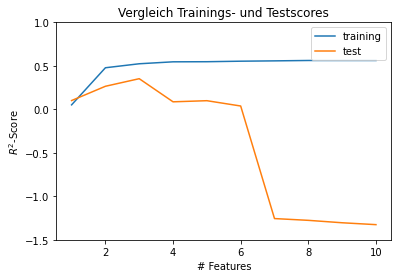

In [10]:
R2.plot(ylim=[-1.5, 1],title="Vergleich Trainings- und Testscores").set(xlabel="# Features", ylabel="$R^2$-Score");

We see that the coefficient of determination for the prediction of training data increases with each additional feature. So if you only evaluated the models with the training data, it would look as if the model gets better with every added feature.

However, this is not the case with the test data. First the *R²* values increase up to a model with three features. After that, however, the prediction accuracy decreases with each additional feature. So although a 10 feature model has much more information at its disposal, it does not predict the test data as well as a model with only three features.

The model with three features appears here to be the optimal compromise between *bias* and *variance*.

If you want, you can use the following code cell to use the *mean squared error* for the same exercise. As the model becomes increasingly complex, it should steadily decrease (training data), or first decrease and then increase (test data). This part of the lesson is optional. You don't have to work through it to complete this course successfully.


MSE (training):  0.051
MSE (test):  11.89 

MSE (training):  0.478
MSE (test):  9.72 

MSE (training):  0.524
MSE (test):  8.568 

MSE (training):  0.546
MSE (test):  12.084 

MSE (training):  0.547
MSE (test):  11.914 

MSE (training):  0.554
MSE (test):  12.722 

MSE (training):  0.557
MSE (test):  29.84 

MSE (training):  0.562
MSE (test):  30.11 

MSE (training):  0.562
MSE (test):  30.479 

MSE (training):  0.562
MSE (test):  30.765 



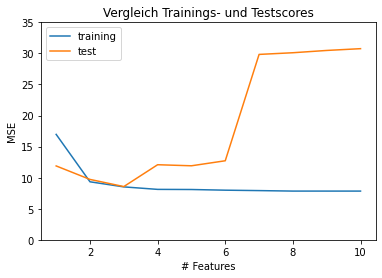

In [11]:
MSE = pd.DataFrame({'training':[],
                  'test': []})

for i in range(1, len(df.columns)-2):  # for each feature (not target)
    
    #print('Features: ', df.columns[:i].format())
    
    # instantiate model
    model_tmp = LinearRegression()
    
    # feature matrix and target vector
    features = df.loc[:, df.columns[:i]]  # feature matrix for training data
    target = df.loc[:, 'price_per_m2']  # target vector for training data
    
    # model fitting
    model_tmp.fit(features, target)
    
    # model predictions (training data)
    target_pred = model_tmp.predict(features)  # predict target values of training data
    residuals = target - target_pred  # difference between predicted and actual target values 
    
    MSE.loc[i, 'training'] = mean_squared_error(target, target_pred)  # calculate MSE for training data and add it to DataFrame
    print('MSE (training): ', round(R2.loc[i, 'training'], 3))

    # model predictions (test data)
    features_test = df_test.loc[:, df_test.columns[:i]]  # feature matrix for test data
    target_test = df_test.loc[:, 'price_per_m2']  # target_values of test data
    target_test_pred = model_tmp.predict(features_test)  # predict target values of test data

    MSE.loc[i, 'test'] = mean_squared_error(target_test, target_test_pred)  # calculate MSE for test data and add it to DataFrame
    print('MSE (test): ', round(MSE.loc[i, 'test'], 3), '\n')

MSE.plot(ylim=[0,35],title="Vergleich Trainings- und Testscores").set(xlabel="# Features", ylabel="MSE");

**Congratulations:** You got your first impression of overfitting. If machine learning models from supervised learning show too much *variance*, they practically learn the training data by heart. This happens when there are too many parameters for the model to learn. A linear regression model with eleven features learns twelve parameters (one axis intercept and eleven slopes).

There are only two remedies to avoid overfitting:
1. More training data
2. A simpler model

In the next lesson you will look at a strategy for finding an optimally simple regression model.


**Remember:**
* Too many features can lead to overfitting.
* If the model is overfitted, it can only handle new data with difficulty.


***
Do you have any questions about this exercise? Look in the forum to see if they have already been discussed.
***
Found a mistake? Contact Support at support@stackfuel.com.
***
